In [1]:
import pandas as pd
import numpy as np

## Match CCMT patents to nongreen ones

In [ ]:
cpc = pd.read_parquet(
    "../patstat/tls225.parquet",
    columns=['docdb_family_id','cpc4d'],
)
cpc = cpc[cpc.cpc4d.str[:3].isin(['Y02','Y04'])][['docdb_family_id']].drop_duplicates().assign(ccmt=True)
cpc.head()

,docdb_family_id,ccmt
40,2985,True
77,4031,True
98,6071,True
173,9985,True
184,10027,True


In [3]:
patvecdf = pd.read_parquet('data/patvecdf.parquet',columns=['patent_id','docdb_family_id'])
patvecdf.head()

,patent_id,docdb_family_id
0,10000000,55456961
1,10000001,56163195
2,10000002,53493659
3,10000003,48045399
4,10000004,56234461


In [4]:
patvecdf.shape

(8436247, 2)

In [5]:
patvec_idx = patvecdf.reset_index().dropna().merge(cpc,how='left').fillna(False)
patvec_idx.head()

,index,patent_id,docdb_family_id,ccmt
0,0,10000000,55456961,False
1,1,10000001,56163195,False
2,2,10000002,53493659,False
3,3,10000003,48045399,False
4,4,10000004,56234461,False


In [6]:
patvec_idx.ccmt.shape,patvec_idx.ccmt.sum()

((6621767,), 340900)

In [ ]:
## use family id to deduplicate
patvec_idx = patvec_idx[['index','docdb_family_id','ccmt']].drop_duplicates(subset=['docdb_family_id'])
patvec_idx.ccmt.shape,patvec_idx.ccmt.sum()

((5734067,), 288579)

In [ ]:
## load patents text embeddings
patvec = np.load('../patent_text/fse_embedding/title_abstract_embedding.npy')
patvec.shape

(8436247, 300)

In [ ]:
## separate into CCMT and nongreen sets
patvec_ccmt = patvec[patvec_idx[patvec_idx.ccmt]['index'],:]
patvec_other = patvec[patvec_idx[~patvec_idx.ccmt]['index'],:]
patvec_ccmt.shape, patvec_other.shape

((288579, 300), (5445488, 300))

In [10]:
del patvec

## Use HNSW in nmslib to match CCMT

In [11]:
import nmslib

In [12]:
index = nmslib.init(method='hnsw', space='cosinesimil')

In [13]:
index.addDataPointBatch(patvec_other)

5445488

In [14]:
index.createIndex(print_progress=True) 


0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


In [15]:
index.saveIndex('data/hnsw_cos_index_patvec_other.bin', save_data=True)

In [16]:
matched = index.knnQueryBatch(patvec_ccmt, k=10)

In [17]:
df_matched = pd.DataFrame(matched,columns=['idx','cos']).reset_index()
df_matched.head()

,index,idx,cos
0,0,"[2587958, 2800154, 4064549, 3623389, 3563498, ...","[0.29003155, 0.3314709, 0.3366409, 0.33757633,..."
1,1,"[4836872, 3911259, 2947853, 1854582, 2942633, ...","[0.17315382, 0.17516488, 0.1752541, 0.18122065..."
2,2,"[1694146, 4423284, 1340024, 367260, 2758352, 7...","[0.21735555, 0.24394912, 0.24443388, 0.2551789..."
3,3,"[3660878, 3402815, 4806288, 757333, 3818505, 3...","[0.22268611, 0.23808455, 0.24158895, 0.2474194..."
4,4,"[96089, 4002091, 3017262, 4581400, 443926, 313...","[0.17031789, 0.17091668, 0.17147112, 0.1826314..."


In [18]:
df_idx = df_matched[['index','idx']].explode('idx')
df_cos = df_matched[['index','cos']].explode('cos')
df_idx.shape, df_cos.shape

((2885790, 2), (2885790, 2))

In [19]:
df_matched_expand = df_idx.assign(cos = df_cos.cos)
df_matched_expand.head()

,index,idx,cos
0,0,2587958,0.290032
0,0,2800154,0.331471
0,0,4064549,0.336641
0,0,3623389,0.337576
0,0,3563498,0.342262


In [20]:
df_matched_expand.shape

(2885790, 3)

In [21]:
df_matched_expand = df_matched_expand.merge(
    patvec_idx[patvec_idx.ccmt][["docdb_family_id"]].rename(
        columns={"docdb_family_id": "ccmt_family_id"}
    ).reset_index(drop=True),
    left_on="index",
    right_index=True,
)
df_matched_expand.head()

,index,idx,cos,ccmt_family_id
0,0,2587958,0.290032,53794004
0,0,2800154,0.331471,53794004
0,0,4064549,0.336641,53794004
0,0,3623389,0.337576,53794004
0,0,3563498,0.342262,53794004


In [22]:
df_matched_expand = df_matched_expand.rename(
        columns={"ccmt_family_id": "ccmt_patent_id"}
    ).merge(
    patvec_idx[~patvec_idx.ccmt][["docdb_family_id"]].rename(
        columns={"docdb_family_id": "patent_id"}
    ).reset_index(drop=True),
    left_on="idx",
    right_index=True,
)
df_matched_expand.head()

,index,idx,cos,ccmt_patent_id,patent_id
0,0,2587958,0.290032,53794004,8166140
0,0,2800154,0.331471,53794004,34394408
147347,147347,2800154,0.211937,40342853,34394408
0,0,4064549,0.336641,53794004,41401672
0,0,3623389,0.337576,53794004,39667457


In [23]:
(df_matched_expand.cos>0).sum(),df_matched_expand.shape

(2884042, (2885790, 5))

In [24]:
df_matched_expand=df_matched_expand.sort_values(['ccmt_patent_id','cos','patent_id',]).reset_index(drop=True)
df_matched_expand.head(15)

,index,idx,cos,ccmt_patent_id,patent_id
0,90572,309667,0.186756,1187498,24371233
1,90572,1457828,0.191544,1187498,25512219
2,90572,632392,0.191563,1187498,11782729
3,90572,417641,0.195533,1187498,25511142
4,90572,4457264,0.195809,1187498,40387622
5,90572,509512,0.196449,1187498,9232695
6,90572,1914107,0.200936,1187498,25537361
7,90572,541048,0.201647,1187498,26736381
8,90572,644281,0.202524,1187498,26732276
9,90572,534267,0.203068,1187498,26736382


In [25]:
df_matched_expand.cos.max(),df_matched_expand.cos.min()

(0.71998185, 0.0)

In [26]:
df_matched_expand['idx']=df_matched_expand['idx'].astype(int)
df_matched_expand['cos']=df_matched_expand['cos'].astype(float)

In [27]:
df_matched_expand.dtypes

index               int64
idx                 int64
cos               float64
ccmt_patent_id      Int64
patent_id           Int64
dtype: object

In [28]:
df_matched_expand.to_parquet('data/matched_ccmt_other.parquet',index=False)

<Axes: ylabel='Frequency'>

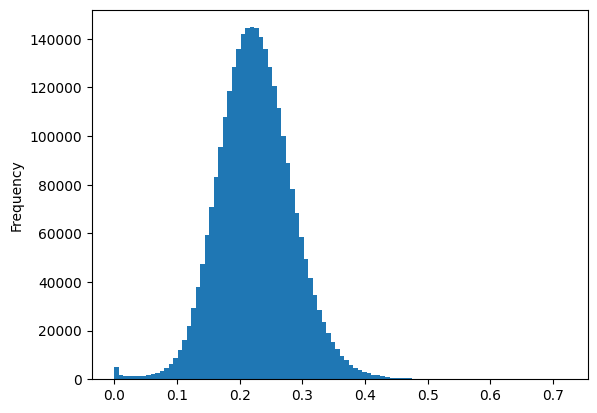

In [29]:
df_matched_expand.cos.plot.hist(bins=100)

In [30]:
df_matched2 = df_matched_expand.rename(
    columns={"ccmt_patent_id": "ccmt_docdb_family_id", "patent_id": "docdb_family_id"}
)
print(df_matched2.shape)
df_matched2.head()

(2885790, 5)


,index,idx,cos,ccmt_docdb_family_id,docdb_family_id
0,90572,309667,0.186756,1187498,24371233
1,90572,1457828,0.191544,1187498,25512219
2,90572,632392,0.191563,1187498,11782729
3,90572,417641,0.195533,1187498,25511142
4,90572,4457264,0.195809,1187498,40387622


In [31]:
df_matched2 = df_matched2[['cos','ccmt_docdb_family_id','docdb_family_id']].merge(
    patvecdf[["patent_id", "docdb_family_id"]].rename(
        columns={"docdb_family_id": "ccmt_docdb_family_id","patent_id":"ccmt_patent_id"}
    )
).merge(patvecdf[["patent_id", "docdb_family_id"]])
df_matched2.head()

,cos,ccmt_docdb_family_id,docdb_family_id,ccmt_patent_id,patent_id
0,0.186756,1187498,24371233,5946941,4123914
1,0.236607,19565893,24371233,6324865,4123914
2,0.246933,22483130,24371233,5377243,4123914
3,0.237356,25094730,24371233,5169413,4123914
4,0.228729,25407669,24371233,5237832,4123914


In [33]:
df_matched2.to_parquet('data/tocheck.parquet',index=False)

In [34]:
df_matched.shape, df_matched2.shape

((288579, 3), (3937424, 5))